In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
data_df = pd.read_pickle('cleaned_features.pkl')
y_label = pd.read_pickle('label.pkl')
feature_columns = data_df.columns

In [3]:
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(data_df[feature_columns], y_label, test_size=0.33, random_state=42)

In [ ]:
y_label.sum()/float(len(y_label))

* Imbalanced classes

### Grid Search for Gradient Boosting

In [4]:
GB = GradientBoostingClassifier(n_estimators = 300)

In [5]:
tuned_parameters = [{'learning_rate': [0.1],
                     'max_depth':[3,5]}]
scores = ['f1']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print 

    clf = GridSearchCV(GB, tuned_parameters, cv=5,
                       scoring = score,verbose=True)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:",clf.best_params_
    print
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
    print

    print "Detailed classification report:"
    print 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print 
    y_true, y_pred,y_prob = y_test, clf.predict(X_test),clf.predict_proba(X_test)
    print classification_report(y_true, y_pred)
    print


# Tuning hyper-parameters for f1

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 252.1min finished


Best parameters set found on development set: {'learning_rate': 0.1, 'max_depth': 5}

Grid scores on development set:
0.705 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 3}
0.739 (+/-0.002) for {'learning_rate': 0.1, 'max_depth': 5}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      1.00      0.98    598528
          1       1.00      0.59      0.74     63808

avg / total       0.96      0.96      0.96    662336




In [37]:
clf.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [19]:
def RF_feature_rank(model,topk=15):
    # get feature names
    feature_names = X_train.columns
    # get feature average score
    feature_mean_score = model.best_estimator_.feature_importances_
    
    # create a dataframe
    feature_df = pd.DataFrame({'feature_names':feature_names,
                               'feature_score':feature_mean_score,
                               })
    # get most siginificant features 
    top_features = feature_df.sort_values('feature_score').iloc[-topk:]
    # generate bar plot
    fig,ax=plt.subplots()
    ax = top_features['feature_score'].plot.barh(title='feature_importances')
    ax.set_xlabel('feature score')
    ax.set_ylabel('features')
    ax.set_yticklabels(top_features['feature_names'])

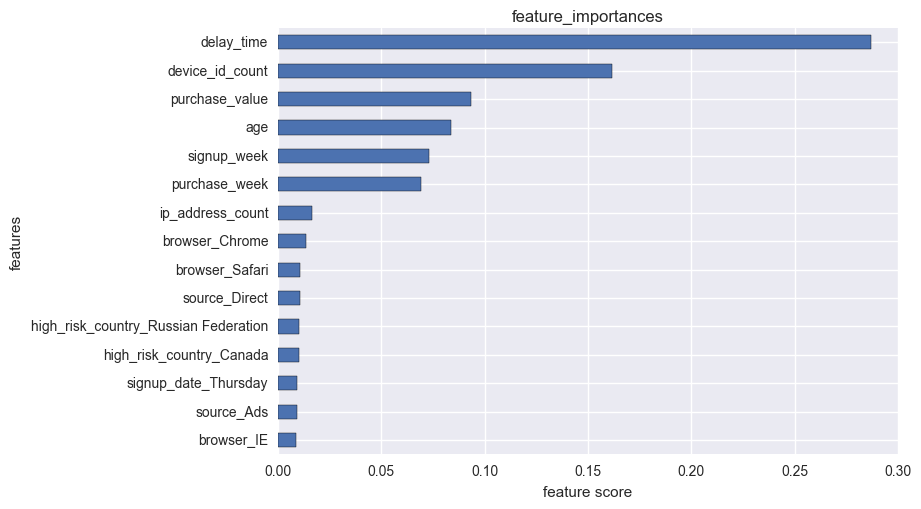

In [20]:
RF_feature_rank(clf)

In [21]:
def plot_confusion_matrix(ytest,ypredict):
    cm =confusion_matrix(ytest, ypredict)
    row_sums = cm.astype('float').sum(axis=1,keepdims=True)
    RF_cm = cm / row_sums
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(RF_cm,annot=True)
    ax.set(xlabel='Predicted Label',ylabel='True Label')

In [22]:
def plot_binary_ROC(ytest,yprob):
    fpr,tpr,_= roc_curve(ytest,yprob)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve(area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    

In [35]:
def find_threshold(ytrue,yprob,th =[0.1,0.2]):
    for t in th:
        y_th = (yprob > t).astype(int)
        plot_confusion_matrix(ytrue,y_th)

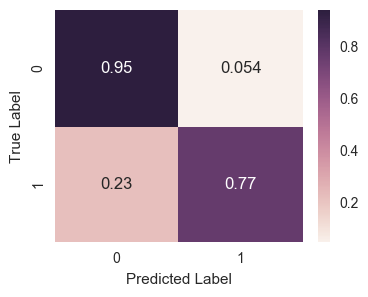

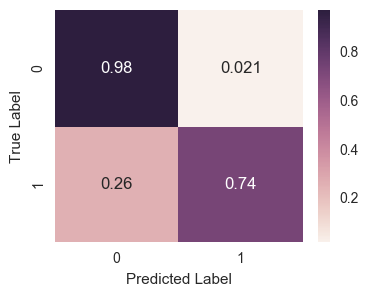

In [36]:
find_threshold(y_true,y_prob[:,1])

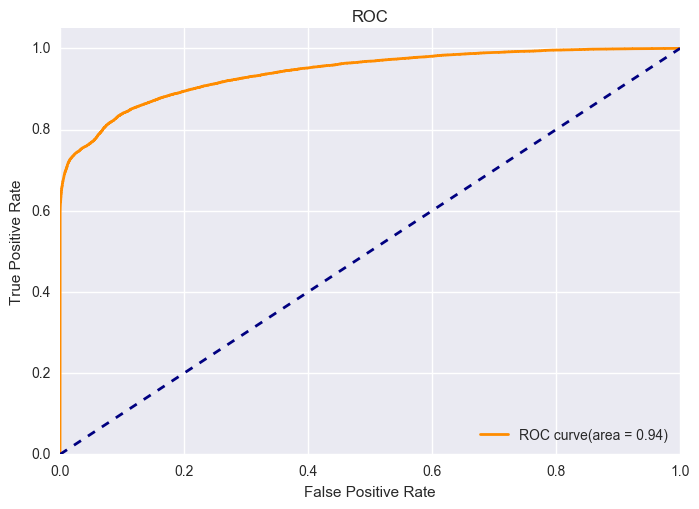

In [24]:
plot_binary_ROC(y_true,y_prob[:,1])